## LPV SUBNET

A reproduction and extention of [https://arxiv.org/abs/2204.04060](https://arxiv.org/abs/2204.04060)

Data download at: https://drive.google.com/drive/folders/1IwUbc2EFrbChMuF-i64s_RDlixLSEKsu?usp=sharing

There are some key difference in this reproduction w.r.t. the original.

 - The inputs used where `u` and `q1_ref` 
   - Old: `out['u_i2'], out['u_q1dref']`
   - New: `out['u_i2']` (I will do 3 different configurations)
 - There where 2 extra training sets present. Having this extra training data seems to have helped a lot.
 - The validation loop was done on the test set which is not the way to go.
 - The test set was noiseless
 - There is slow $T$ increasing used ("The truncation length T is initially set to 5 and has been increased to 60 in the first few epochs to enhance training stability.") 

The example runs 4 models on 3 different input configurations:

### Input Configurations:
* `'just u'`: Only the input `u` is included.
* `'p in u'`: The schedualing parameter `p` (`q1d` and `q4d`?) is included in the input `u`.
* `'q1dref in u'`: The reference signal `q1dref` is included in the input `u`. (as was done in the original paper)

### Models:
1. `SUBNET`
2. `SUBNET_CT`
3. `SUBNET_LPV` (https://arxiv.org/abs/2204.04060)
4. `SUBNET_LPV_ext_scheduled` (LPV system identification approach LPV_SUBNET with external scheduling as seen in Fig. 2 in https://arxiv.org/pdf/2204.04060)

To note is that the estimation of the LPV and the CT SUBNET was not that stable for the `just u` an dthe `p in u` case. This can be improved with a variable truncation lenght in the SUBNET loss depdent on the deviation from the data.

### Results: 

Estimation/Train/`estim.mat` set **RMS** simulation:

|             |     SUBNET |   SUBNET_CT |   SUBNET_LPV |   SUBNET_LPV_ext_scheduled |
|:------------|-----------:|------------:|-------------:|---------------------------:|
| just u      | 0.174062   | 0.051818    |   0.249903   |                 0.00706525 |
| p in u      | 0.004825   | 0.004768    |   0.005582   |                 0.00499340 |
| q1dref in u | 0.095633   | nan         |   0.271521   |                 0.00590125 |

Estimation/Train/`estim.mat` set **BFR** simulation:

|             |   SUBNET |    SUBNET_CT |   SUBNET_LPV |   SUBNET_LPV_ext_scheduled |
|:------------|---------:|-------------:|-------------:|---------------------------:|
| just u      | 0.534954 |  0.958786    |    0.0414103 |                   0.999234 |
| p in u      | 0.999643 |  0.999651    |    0.999522  |                   0.999617 |
| q1dref in u | 0.85962  | -4.69199e+20 |   -0.131608  |                   0.999465 |


Test/`ML_valid_noisy.mat` set RMS simulation:

|             |     SUBNET |    SUBNET_CT |   SUBNET_LPV |   SUBNET_LPV_ext_scheduled |
|:------------|-----------:|-------------:|-------------:|---------------------------:|
| just u      | 0.204567   |   0.252856   |   0.253313   |                 0.00993821 |
| p in u      | 0.005154   |   0.005259   |   0.007819   |                 0.00524803 |
| q1dref in u | 0.135145   | nan          |   0.274934   |                 0.00639329 |


Test/`ML_valid_noisy.mat` set **BFR** simulation:

|             |   SUBNET |   SUBNET_CT |   SUBNET_LPV |   SUBNET_LPV_ext_scheduled |
|:------------|---------:|------------:|-------------:|---------------------------:|
| just u      | 0.374485 |    0.044313 |    0.0408534 |                   0.998524 |
| p in u      | 0.999603 |    0.999587 |    0.999086  |                   0.999588 |
| q1dref in u | 0.726995 |  nan        |   -0.129859  |                   0.999389 |


Please note that the, SUBNET_LPV_ext_scheduled has access to the current output, so it cannot be applied without a known output signal. (i.e. it's not a true simulation)

Also `SUBNET_CT` results might be able to be improved by selecting a better CT normalization constant $\tau$

## Load the data:

In [1]:
import deepSI as dsi
import numpy as np
from deepSI.models import SUBNET_LPV, SUBNET_LPV_ext_scheduled, SUBNET, SUBNET_CT
import cloudpickle
from scipy.io import loadmat
from matplotlib import pyplot as plt
import torch
import cloudpickle

def get_data(include='just u'):
    train_full = loadmat('./data/estim.mat')
    test_full = loadmat('./data/valid_noisy.mat')

    u_train = train_full['exp_u']
    y_train = train_full['exp_y']
    p_train = train_full['exp_p']
    if include=='p in u':
        u_train = np.concat([u_train,p_train],axis=1).copy()
    elif include=='q1dref in u':
        train_val_2_mat = loadmat('./data/ML_estim.mat')
        u_train = np.concat([u_train,train_val_2_mat['u_q1dref']],axis=1).copy()

    u_test = test_full['exp_u']
    y_test = test_full['exp_y']
    p_test = test_full['exp_p']
    if include=='p in u':
        u_test = np.concat([u_test,p_test],axis=1).copy()
    elif include=='q1dref in u':
        test_2_mat = loadmat('./data/ML_valid.mat')
        u_test = np.concat([u_test,test_2_mat['u_q1dref']],axis=1).copy()
    
    train_val = dsi.Input_output_data(u_train, y_train, sampling_time=1.0)
    test = dsi.Input_output_data(u_test, y_test, sampling_time=1.0)
    s = int(len(train_val)*0.90)
    train, val = train_val[:s], train_val[s:]
    return train, val, test


## Estimate the models:

In [ ]:
#Skip this cell if don't want to train the models

import os
for include in ['just u','p in u','q1dref in u']:
    train, val, test = get_data(include)
    nu, ny, norm = dsi.get_nu_ny_and_auto_norm(train)
    for Model in [SUBNET, SUBNET_CT, SUBNET_LPV, SUBNET_LPV_ext_scheduled]:
        name = Model.__name__
        file_name = f'models/{name}-{include}-T-60.pth'
        if os.path.exists(file_name):
            print('XXXXXXXXXXXXXXXXX Already exists XXXXXXXXXXXXXXXXXXX', name, include)
            continue
        
        seed = 1
        torch.manual_seed(seed)
        if name in ['SUBNET_LPV', 'SUBNET_LPV_ext_scheduled']:
            model = Model(nu, ny, norm, nx=5, n_schedual=3, na=5, nb=5)
        else:
            model = Model(nu, ny, norm, nx=5, na=5, nb=5)
        try:
            fit_res = dsi.fit(model, train, val, n_its=100_000, T=60, val_freq=100)
        except ValueError:
            print('XXXXXXXXXXXXXXXXX Failed XXXXXXXXXXXXXXXXXXX', name, include, seed)
            continue
        cloudpickle.dump(model, open(f'models/{name}-{include}-{seed}-T-60.pth','wb'))
        cloudpickle.dump((fit_res,seed), open(f'models/{name}-{include}-{seed}-fit-res-T-60.pth','wb'))



## Recover any crashed models

In [ ]:
#skip if you don't want to copy the files (e.g. didn't run the above cell)
from deepSI.fitting import get_checkpoint_dir
import os

# get the files in the checkpoint directory that are the 8 recent files:
def get_recent_files(checkpoint_dir, n=8):
    files = os.listdir(checkpoint_dir)
    files = [f for f in files if f.endswith('.pth')]
    files.sort(key=lambda x: os.path.getmtime(os.path.join(checkpoint_dir, x)), reverse=True)
    files = files[:n]
    files.reverse()
    return files

files = get_recent_files(get_checkpoint_dir(), n=4*3)
i = 0
for include in ['just u','p in u','q1dref in u']:
    for Model in [SUBNET, SUBNET_CT, SUBNET_LPV, SUBNET_LPV_ext_scheduled]:
        name = Model.__name__
        file = files[i]
        i += 1
        #copy file to models with new name:
        new_file = f'./models/{name}-{include}-T-60-copy.pth'
        import shutil
        shutil.copy2(os.path.join(get_checkpoint_dir(), file), new_file)



## Plot trainig curves:

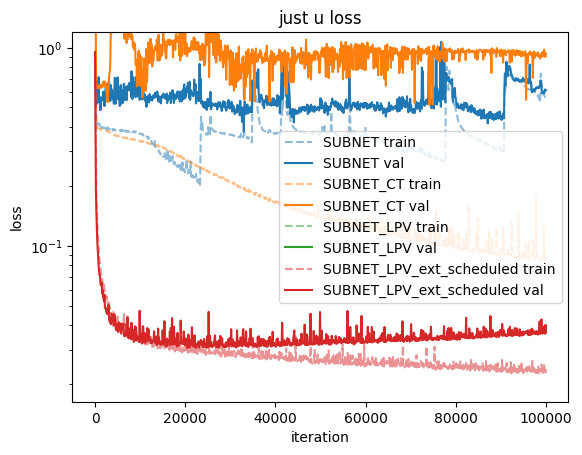

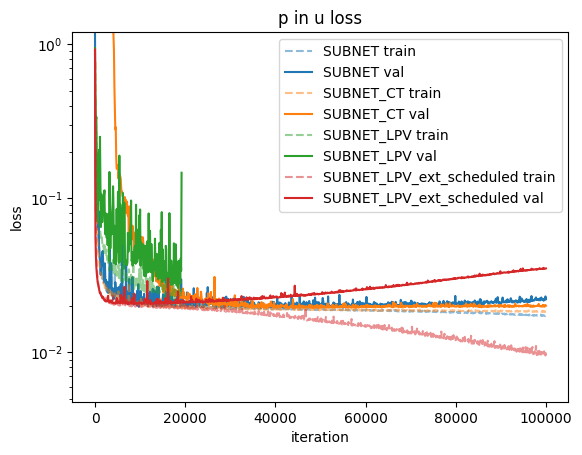

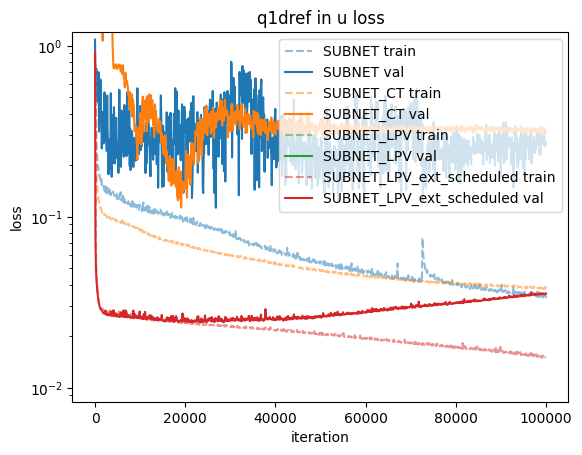

In [3]:
for include in ['just u','p in u','q1dref in u']:
    train, val, test = get_data(include)
    
    for color, Model in zip(plt.rcParams['axes.prop_cycle'], [SUBNET, SUBNET_CT, SUBNET_LPV, SUBNET_LPV_ext_scheduled]):
        name = Model.__name__
        file = f'./models/{name}-{include}-T-60-copy.pth'
        res_fit = cloudpickle.load(open(file, 'rb'))

        plt.semilogy(res_fit['it_counter'], res_fit['NRMS_train'], '--', label=name + ' train', alpha=0.5, color=color['color'])
        plt.semilogy(res_fit['it_counter'], res_fit['NRMS_val'], label=name + ' val', color=color['color'])
        ylims = plt.ylim()
    plt.ylim(ylims[0], 1.2)
    plt.legend()
    plt.xlabel('iteration')
    plt.ylabel('loss')
    plt.title(f'{include} loss')
    plt.show()

## Precompute simulation outputs for test and train sets:

In [4]:
simulations = {}
for include in ['just u','p in u','q1dref in u']:
    train, val, test = get_data(include)
    for color, Model in zip(plt.rcParams['axes.prop_cycle'], [SUBNET, SUBNET_CT, SUBNET_LPV, SUBNET_LPV_ext_scheduled]):
        print('include', include)
        print('Model', Model.__name__)
        name = Model.__name__
        file = f'./models/{name}-{include}-T-60-copy.pth'
        res_fit = cloudpickle.load(open(file, 'rb'))
        model = res_fit['best_model']

        test_p = model.simulate(test)
        train_p = model.simulate(train)
        simulations[(include, name, 'test')] = test_p
        simulations[(include, name, 'train')] = train_p

include just u
Model SUBNET
include just u
Model SUBNET_CT
include just u
Model SUBNET_LPV
include just u
Model SUBNET_LPV_ext_scheduled
include p in u
Model SUBNET
include p in u
Model SUBNET_CT
include p in u
Model SUBNET_LPV
include p in u
Model SUBNET_LPV_ext_scheduled
include q1dref in u
Model SUBNET
include q1dref in u
Model SUBNET_CT
include q1dref in u
Model SUBNET_LPV
include q1dref in u
Model SUBNET_LPV_ext_scheduled


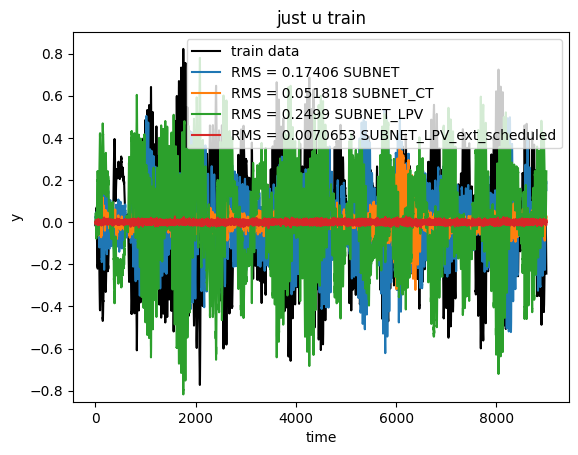

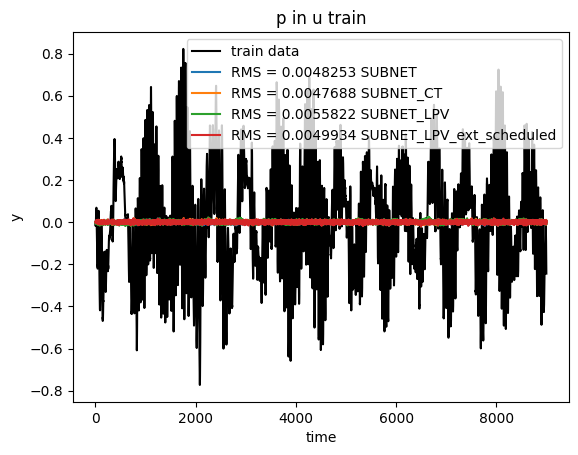

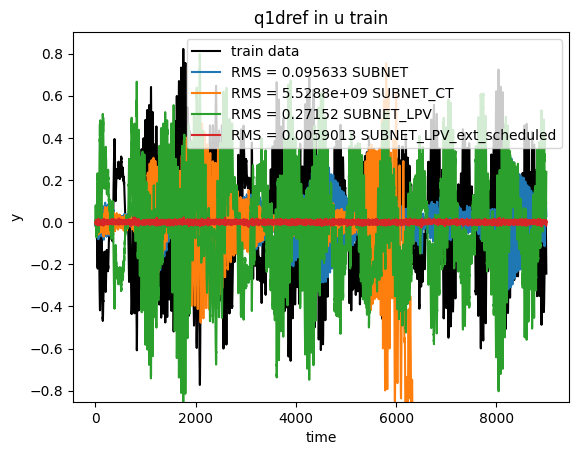

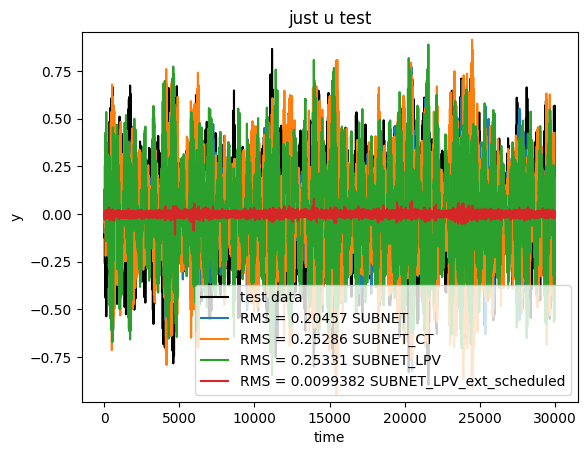

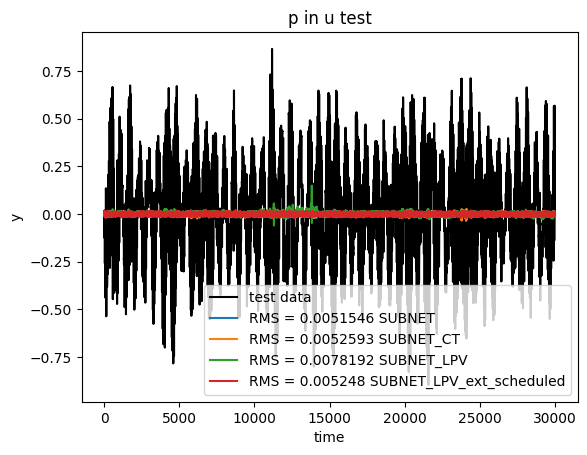

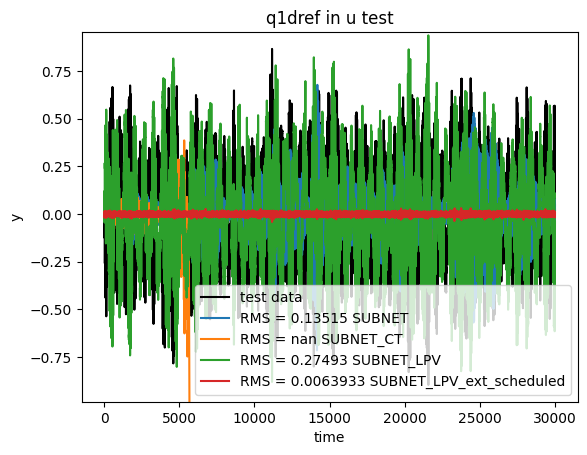

In [17]:
# test_ps = []
import pandas as pd
dfs = []

for kind in ['train','test']:
    BFRes = []
    RMSes = []
    i = 0
    for include in ['just u','p in u','q1dref in u']:
        train, val, test = get_data(include)
        data = test if kind=='test' else train
        plt.plot(data.y[:,0], 'k', label=f'{kind} data')
        ylim = plt.ylim()
        
        for color, Model in zip(plt.rcParams['axes.prop_cycle'], [SUBNET, SUBNET_CT, SUBNET_LPV, SUBNET_LPV_ext_scheduled]):
            name = Model.__name__
            file = f'./models/{name}-{include}-T-60-copy.pth'
            res_fit = cloudpickle.load(open(file, 'rb'))
            model = res_fit['best_model']
            data_p = simulations[(include, name, kind)]
            RMS = ((data_p.y - data.y)**2).mean()**0.5
            RMSes.append(RMS)
            BFRes.append(1-RMS**2/data.y.var())

            plt.plot(data_p.y[:,0] - data.y[:,0], label=f'RMS = {RMS:.5} {name}')
        plt.legend()
        plt.xlabel('time')
        plt.ylabel('y')
        plt.title(f'{include} {kind}')
        plt.ylim(ylim[0], ylim[1])
        plt.show()

    df = pd.DataFrame(np.array(RMSes).reshape((3,4)), columns=['SUBNET', 'SUBNET_CT', 'SUBNET_LPV', 'SUBNET_LPV_ext_scheduled'], index=['just u','p in u','q1dref in u'])
    
    df_BFR = pd.DataFrame(np.array(BFRes).reshape((3,4)), columns=['SUBNET', 'SUBNET_CT', 'SUBNET_LPV', 'SUBNET_LPV_ext_scheduled'], index=['just u','p in u','q1dref in u'])
    dfs.extend([df, df_BFR])


In [18]:
print(dfs[0].to_markdown()) #train RMS

|             |     SUBNET |   SUBNET_CT |   SUBNET_LPV |   SUBNET_LPV_ext_scheduled |
|:------------|-----------:|------------:|-------------:|---------------------------:|
| just u      | 0.174062   | 0.051818    |   0.249903   |                 0.00706525 |
| p in u      | 0.00482535 | 0.0047688   |   0.00558223 |                 0.0049934  |
| q1dref in u | 0.0956331  | 5.52884e+09 |   0.271521   |                 0.00590125 |


In [20]:
print(dfs[1].to_markdown()) #train BFR

|             |   SUBNET |    SUBNET_CT |   SUBNET_LPV |   SUBNET_LPV_ext_scheduled |
|:------------|---------:|-------------:|-------------:|---------------------------:|
| just u      | 0.534954 |  0.958786    |    0.0414103 |                   0.999234 |
| p in u      | 0.999643 |  0.999651    |    0.999522  |                   0.999617 |
| q1dref in u | 0.85962  | -4.69199e+20 |   -0.131608  |                   0.999465 |


In [21]:
print(dfs[2].to_markdown()) #test RMS

|             |     SUBNET |    SUBNET_CT |   SUBNET_LPV |   SUBNET_LPV_ext_scheduled |
|:------------|-----------:|-------------:|-------------:|---------------------------:|
| just u      | 0.204567   |   0.252856   |   0.253313   |                 0.00993821 |
| p in u      | 0.00515463 |   0.00525929 |   0.00781921 |                 0.00524803 |
| q1dref in u | 0.135145   | nan          |   0.274934   |                 0.00639329 |


In [22]:
print(dfs[3].to_markdown()) #test BFR

|             |   SUBNET |   SUBNET_CT |   SUBNET_LPV |   SUBNET_LPV_ext_scheduled |
|:------------|---------:|------------:|-------------:|---------------------------:|
| just u      | 0.374485 |    0.044313 |    0.0408534 |                   0.998524 |
| p in u      | 0.999603 |    0.999587 |    0.999086  |                   0.999588 |
| q1dref in u | 0.726995 |  nan        |   -0.129859  |                   0.999389 |
